# Importação dos dados

Foi utilizada o API do Yahoo Finance para obter os dados de cotação histórico do ativo de Open-High-Low-Close (OHLC)

In [1]:
import gymnasium as gym
from ray.rllib.models.preprocessors import get_preprocessor

from TradingEnv import TradingMarket

from gymnasium import spaces
import numpy as np

import pandas as pd
import pandas_datareader.data as pdr
import yfinance

yfinance.pdr_override()

data_inicial = "2012-01-01"
data_final = "2017-12-31"
df = pdr.get_data_yahoo("AAPL", data_inicial, data_final)

# df.columns =  map(lambda x: x.lower(), df.columns)

df

c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-17 10:37:31,104	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-17 10:37:41,806	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449694,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516596,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655556,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787854,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767572,394024400
...,...,...,...,...,...,...
2017-12-22,43.669998,43.855000,43.625000,43.752499,41.372990,65397600
2017-12-26,42.700001,42.867500,42.419998,42.642502,40.323353,132742000
2017-12-27,42.525002,42.695000,42.427502,42.650002,40.330452,85992800


In [75]:
from tsfresh.utilities.dataframe_functions import roll_time_series
ts = df.reset_index()[["Date", "Close"]]
ts['Close'] = np.log(ts['Close'])
ts['id'] = 1

res = roll_time_series(ts, column_id='id', column_sort="Date", min_timeshift=14, max_timeshift=14)
feat = extract_features(res, column_id="id", column_sort="Date", default_fc_parameters=fc_parameters)
feat = feat.reset_index(level=1).reset_index(drop=True).rename({"level_1": "Date"}, axis=1)

for i in [1] + list(range(5, 15, 5)):
    ts[f'return_lag_{i}'] = ts['Close'].shift(i-1) - ts['Close'].shift(i)

feat.merge(ts, on="Date").drop("id", axis=1).drop('Date', axis=1)

c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling:   0%|          | 0/20 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


,Close__mean,Close__standard_deviation,Close__minimum,Close__maximum,Close,return_lag_1,return_lag_5,return_lag_10
0,2.711710,0.011244,2.686948,2.729509,2.709026,-0.016513,0.010330,0.003574
1,2.717220,0.016690,2.692308,2.769593,2.769593,0.060567,-0.003174,-0.001632
2,2.722069,0.019134,2.703349,2.769593,2.765038,-0.004555,-0.017570,-0.002749
3,2.726577,0.021952,2.707598,2.770980,2.770980,0.005942,0.016775,-0.003757
4,2.731242,0.025822,2.707598,2.783710,2.783710,0.012729,-0.016513,0.011581
...,...,...,...,...,...,...,...,...
1490,3.763156,0.013875,3.743663,3.786573,3.778549,0.000000,0.013985,0.019297
1491,3.763458,0.013595,3.743663,3.786573,3.752851,-0.025697,-0.010714,-0.005633
1492,3.763834,0.013218,3.743663,3.786573,3.753027,0.000176,-0.001089,0.003314
1493,3.764645,0.012296,3.745496,3.786573,3.755837,0.002810,0.003778,-0.000290


In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['Close'])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize =(15, 10))
plt.yticks(fontsize=20)
fig.suptitle("Exemplos de episódios em diferente reinicializações do ambiente", fontweight = "bold", fontsize=20)
ax[0].set_title("Episódio A", fontsize =18, loc='left')
ax[0].plot(df['Close'], color='blue', label='Cotação do BBAS3')
ax[0].axvspan("2005-01-01", "2005-10-31", alpha=.5, color='red', label='Dias no episódio')
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=14)
ax[0].set_xlabel("Tempo", size=16)
ax[0].set_ylabel("R$", size=16)

plt.yticks(fontsize=20)
ax[1].set_title("Episódio B", fontsize =18, loc='left')
ax[1].plot(df['Close'], color='blue', label='Cotação do BBAS3')
ax[1].axvspan("2019-01-01", "2019-10-31", alpha=.5, color='red', label='Dias no episódio')
ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=14)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=14)
ax[1].set_xlabel("Tempo", size=16)
ax[1].set_ylabel("R$", size=16)
ax[1].legend(bbox_to_anchor=(1.0, 0.5), prop={'size':12})

ax[2].set_title("Episódio C", fontsize =18, loc='left')
ax[2].plot(df['Close'], color='blue', label='Cotação do BBAS3')
ax[2].axvspan("2010-01-01", "2010-10-31", alpha=.5, color='red', label='Dias no episódio')
ax[2].set_yticklabels(ax[2].get_yticklabels(), fontsize=14)
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize=14)
ax[2].set_xlabel("Tempo", size=16)
ax[2].set_ylabel("R$", size=16)


plt.tight_layout()
plt.show()

# Funções de recompensa

As alternativas de recompensa implementada até o momento estão:


*   Logarítimo do retorno
*   Shape ratio
*   Sortino ratio

Mais detalhes sobre essas duas últimas métricas estão disponíveis no entregavél do GATE 4:

https://docs.google.com/document/d/1-xymX7KVVSFVd2N3o1iPpnrDbNlmnz88syhMCVq_ZiY/edit



In [ ]:
def log_return(history):
    return np.log(history[-1]/history[-2])

def sharpe_ratio(history, risk_free=0):
    portifolio_return = np.mean(history)
    portifolio_std = np.std(history)
    return (portifolio_return - risk_free)/portifolio_std

def sortino_ratio(history, risk_free=0):
    portifolio_return = np.mean(history)
    portifolio_std = np.std([x for x in history if x < 0])
    portifolio_std = 1 if str(portifolio_std) == 'nan' else portifolio_std

    return (portifolio_return - risk_free)/portifolio_std

# Versão simplificada do ambiente

Esta versão simplificada do ambiente foi desenvolvida baseada no código do repósitorio:

https://github.com/ClementPerroud/Gym-Trading-Env

Esse repositório já implementa um ambiente para trading seguindo o estrutura dos ambiente do openai gym. É uma implementação bem completa que inclui diversos aspectos do mercado financeiro como taxa de transação, Short selling and Margin Trading.

Contudo, tive um alguns problemas para testar o código disponivel com alguns erros sendo gerados. Por isso, estudei o código fonte e decidi implementar essa primeira versão do ambiente. Para mais detalhes, acessar entregável do GATE 5:

https://docs.google.com/document/d/14VQprimbpDVYgyBsrwqNKn7-xIdIUSNwj_oOVPZ3kWA/edit



In [ ]:
class TradingMarket(gym.Env):
    def __init__(self, data, initial_value=1000, positions=[1, 0], reward_func=log_return, window=15, dt_fim=None, epi_len=300):
        super().__init__()

        self.data = {}
        # self.tickets = tickets
        # for ticket in self.tickets:
        #     self.data[ticket] = pdr.get_data_yahoo(ticket, end=dt_fim)
        self.historical_price = data["data"]
        self.epi_len = epi_len
        self.positions = np.array(positions)
        #print(self.tickets)
        #self.ticket = ticket#np.random.choice(tickets)
        self.initial_value = initial_value
        self.window = window
        self.idx = np.random.randint(self.window, self.historical_price.shape[0] - self.epi_len)
        self.steps = 0
        self.position = 0
        
        self.n_assets = self.position * self.initial_value / self.historical_price.iloc[self.idx, :]['Close']
        self.avaiable_money = (1 - self.position) * self.initial_value


        self.action_space = spaces.Discrete(len(positions))

    #     self.observation_space = spaces.Dict({
    #         "history_data": spaces.Box(
    #                 -np.inf,
    #                 np.inf,
    #                 shape = [self.window],
    #                 dtype=np.float64
    #         ),
    #         "position":spaces.Discrete(2)
    #    })

        self.observation_space = spaces.Box(
                -np.inf,
                np.inf,
                shape = [self.window+2],
                dtype=np.float64
        )

        self.history = [initial_value]
        self.reward_func = reward_func
        self.done = False

    def valorisation(self, price):
        """
        Calcula qual o valor total do patrimônio em reais como preço da ação
        fornecido
        """
        return price*self.n_assets + self.avaiable_money

    def _get_obs(self):
        OHLC = self.historical_price.iloc[self.idx-self.window : self.idx, 3].values
        onehot_action = np.zeros((2), dtype=np.float64)
        onehot_action[np.where(self.positions == self.position)] = 1
        observation = np.concatenate([
            OHLC, 
            onehot_action
        ])
        return observation

    def reset(self, seed=None, options=None):
        """
        Reset o ambiente ambiente para os valores inciais
        """
        np.random.seed(seed)
        self.history = [self.initial_value]
        self.idx = np.random.randint(self.window, self.historical_price.shape[0] - self.epi_len)
        self.steps = 0
        self.done = False
        #self.ticket = self.tickets[0]#np.random.choice(self.tickets)

        # observation = {
        #     "history_data": OHLC, 
        #     "position": 0
        # }

        observation = self._get_obs()

        return observation, {}

    def step(self, desired_position):
        """
        Executa uma ação no ambiente. Nesse caso, rebalancea o portifolio entre
        reais e ações compradas segundo a posição desejada
        """
        price = self.historical_price.iloc[self.idx+1, :]['Close']
        current_value = self.valorisation(price)

        if desired_position != self.position:
            ideal_n_assets = current_value*desired_position/price

            asset_to_trade = ideal_n_assets - self.n_assets

            operation_cost = asset_to_trade * price
            self.avaiable_money = self.avaiable_money - operation_cost
            self.n_assets = self.n_assets + asset_to_trade
            self.position = desired_position

        self.history.append(current_value)

        # observation = {
        #     "history_data": OHLC, 
        #     "position": self.position
        # }

        if self.steps == self.epi_len:
            self.done = True

        self.idx += 1
        self.steps += 1
        reward = self.reward_func(
            self.history[
                max(self.steps-self.window, 0):
                self.steps+1
            ]
        )
        observation = self._get_obs()
        
        return observation, reward, self.done, False, {}

    def reward(self, history, **kwargs):
        """
        Função de recompensa que guiará o aprendizado.
        """
        return self.reward_func(history, **kwargs)

In [ ]:
import torch
from ray.rllib.models.torch.misc import SlimConv2d, SlimFC

models = {
    'channels': [5, 50, 2],
    'kernels': [(3, 1), (13, 1), (1, 1)]
}

data = torch.randn((3, 15))
data = data.unsqueeze(dim=1).unsqueeze(dim=-1)
fc1 = SlimConv2d(1, 5, (3, 1), 1, 0)
fc2 = SlimConv2d(5, 50, (13, 1), 1, 0)
#fc3 = SlimConv2d(50, 2, (1, 1), 1, 0)
fc3 = SlimFC(52, 2)

fc3(torch.cat([fc2(fc1(data)).squeeze(), torch.randint(0, 2, (3, 2))], dim=1)).shape

In [ ]:
env = gym.make("TradeEnv-v0")

obs, _ = env.reset()

In [ ]:
obs[:-2]

In [ ]:
pd.DataFrame({"id":[1]*15, "time": range(15), "close": obs[:-2]})

In [ ]:
import ray
from models.convolutional import ConvModel
from TradingEnv import TradingMarket, log_return
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.algorithms import ppo

ray.init()

# Register the above custom model.
ModelCatalog.register_custom_model("my_torch_model", ConvModel)

# Create the Algorithm from a config object.
config = (
    ppo.PPOConfig()
    .rollouts(
        num_rollout_workers=7,
    )
    .environment(env=TradingMarket, env_config={"data":df})
    .framework("torch")
    .training(
         model={
    #         # Auto-wrap the custom(!) model with an LSTM.
    #         "use_lstm": True,
    #         # To further customize the LSTM auto-wrapper.
    #         "lstm_cell_size": 64,
    #         # Specify our custom model from above.
            "custom_model": "my_torch_model",
    #         # Extra kwargs to be passed to your model's c'tor.
            "custom_model_config": {
                'channels': [5, 50],
                'kernels': [(3, 1), (13, 1)],
                'activation_fn': ['relu', 'relu']
            },
        },
        _enable_learner_api=False
    ).rl_module(_enable_rl_module_api=False)
)
algo = config.build()
algo.train()

for _ in range(5):
    print(algo.train())  # 3. train it,

algo.evaluate() #algo.stop()

In [ ]:
ray.shutdown()

# Exemplo de execução do ambiente

Para esse pequena simulação os dados da ação do Banco do Brasil foram utilizados. Não foi testado nenhum agente, apenas uma estrátegia bem simplória com o uso da média dos últimos dias como referência de alta ou queda para fins.

In [2]:
from TsfreshEnv import TradingMarket, log_return
from utils import compute_features

In [3]:
compute_features(df.reset_index(), 15)

c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\tsfresh\utilities\dataframe_functions.py:520: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  warnings.warn(
Rolling:   0%|          | 0/20 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


,Close__mean,Close__standard_deviation,Close__minimum,Close__maximum,Close,return_lag_1,return_lag_5,return_lag_10
0,2.711710,0.011244,2.686948,2.729509,2.709026,-0.016513,0.010330,0.003574
1,2.717220,0.016690,2.692308,2.769593,2.769593,0.060567,-0.003174,-0.001632
2,2.722069,0.019134,2.703349,2.769593,2.765038,-0.004555,-0.017570,-0.002749
3,2.726577,0.021952,2.707598,2.770980,2.770980,0.005942,0.016775,-0.003757
4,2.731242,0.025822,2.707598,2.783710,2.783710,0.012729,-0.016513,0.011581
...,...,...,...,...,...,...,...,...
1490,3.763156,0.013875,3.743663,3.786573,3.778549,0.000000,0.013985,0.019297
1491,3.763458,0.013595,3.743663,3.786573,3.752851,-0.025697,-0.010714,-0.005633
1492,3.763834,0.013218,3.743663,3.786573,3.753027,0.000176,-0.001089,0.003314
1493,3.764645,0.012296,3.745496,3.786573,3.755837,0.002810,0.003778,-0.000290


In [ ]:
gym.envs.register(
    id='TradeEnv-v0',
    entry_point=TradingMarket,
    kwargs={
        "env_config": {
            "OHCL":df,
            "feat":compute_features(df.reset_index(), 15),
            "initial_value": 1000,
            "positions": [0, 1], 
            "window": 15,
            "epi_len":300
        }
    }
)

In [5]:
env = gym.make('TradeEnv-v0')

In [85]:
#env = gym.make('TradeEnv-v0')
obs, _ = env.reset()
print(env.idx)
done = False
rewards = []
i = 0
while not done:
    i+=1
    if obs[-1] == 0 and obs[0] < obs[4]:
        action = 1
    elif obs[-1] == 1 and obs[0] < obs[4]:
        action = 1
    elif obs[-2] == 0 and obs[0] > obs[4]:
        action = 0
    elif obs[-2] == 1 and obs[0] > obs[4]:
        action = 0

    obs, rwd, done, *_ = env.step(action)

    rewards.append(rwd)
print(env.idx)
print(i)
print(f"Recompensa obtida: {np.exp(np.mean(rewards))}")
last_price = env.historical_price.iloc[env.idx, 3]
print(f"Patrimônio final: {env.valorisation(last_price)}")

225
525
300
Recompensa obtida: 0.9992544805337676
Patrimônio final: 775.5629715972358


In [ ]:
data_inicial = "2020-01-01"
data_final = "2023-12-01"
df_test = pdr.get_data_yahoo("BBAS3.SA", data_inicial, data_final)
df_test

In [3]:
from TradingEnv import TradingMarket, log_return
gym.envs.register(
    id='TradeEnv-v0',
    entry_point=TradingMarket,
    kwargs={
        "env_config": {
            "OHCL":df,
            "initial_value": 1000,
            "positions": [0, 1], 
            "window": 15,
            "epi_len":300
        }
    }
)

In [4]:
env = gym.make('TradeEnv-v0')
obs, _ = env.reset(seed=42)

c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\gymnasium\utils\passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


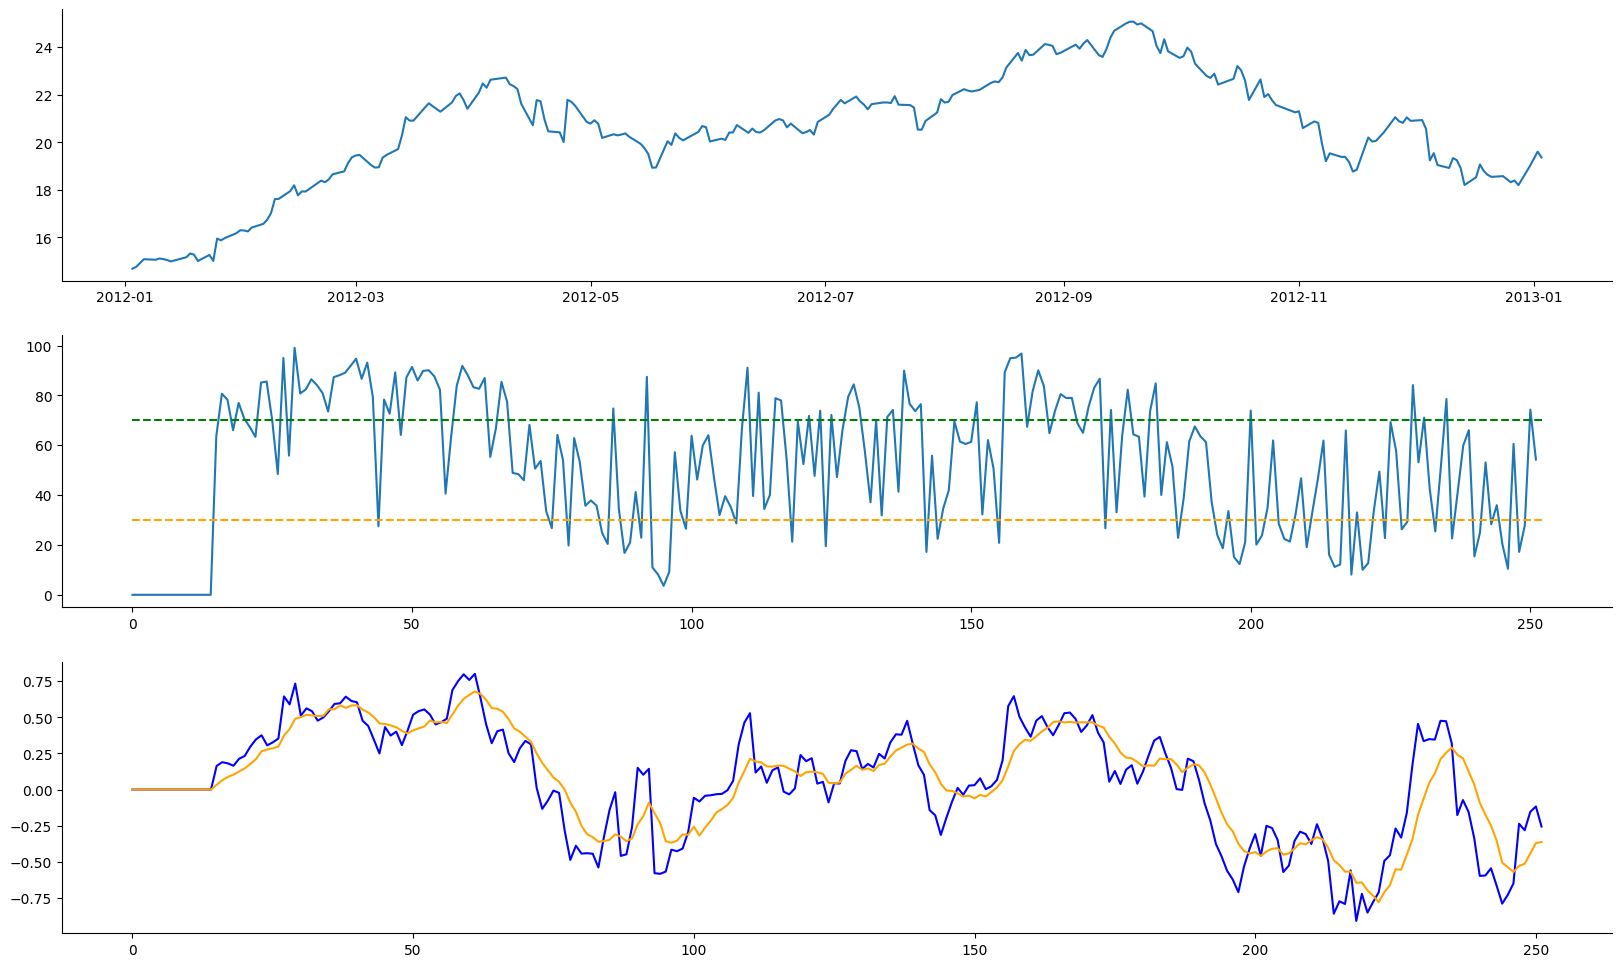

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,12))
plt.subplot(311)
plt.plot(df.iloc[:252]['Close'])
plt.subplot(312)
plt.plot(RSIs[:252])
plt.hlines(70, 0, df.iloc[:252].shape[0], color='green', linestyles='--')
plt.hlines(30, 0, df.iloc[:252].shape[0], color='orange', linestyles='--')
plt.subplot(313)
plt.plot(MACDs[:252], color='blue')
plt.plot(signals[:252], color='orange')
plt.show()

In [47]:
abs(loss)

array([0.        , 0.        , 0.24250031, 0.        , 0.01250076,
       0.        , 0.        , 0.47000122, 0.0474968 , 0.        ,
       0.        , 1.1099968 , 0.        , 0.        ])

In [50]:
import utils
w=15
RSIs = [0]*w
MACDs = [0]*w
signals = [0]*w
for idx in range(w, df.shape[0]):
    ret = df.iloc[idx-w:idx]['Close'] - df.iloc[idx-w:idx]['Close'].shift(1)
    gain = np.array([ 0 if x < 0 else x for x in ret[1:]])
    loss = np.array([ 0 if x > 0 else x for x in ret[1:]])
    average_gain = utils.EMA(gain, a=1/len(gain))
    average_loss = utils.EMA(abs(loss), a=1/len(loss))
    RSIs.append(100 - (100/ (1 + average_gain/average_loss)))

    ema12 = utils.EMA(df.iloc[idx-w:idx]['Close'][-12:], a=2/13)
    ema26 = utils.EMA(df.iloc[idx-w:idx]['Close'][-26:], a=2/27)
    MACDs.append(ema12 - ema26)

    emaMACD = utils.EMA(MACDs[-9:], a=2/10)
    signals.append(emaMACD)

In [13]:
[1, 2, 3][-2:None]

[2, 3]

In [16]:
for i in range(9):
    inf = -35+i+1
    sup = -9+i+1
    sup = sup if sup < 0 else None
    print(' '.join([str(x) for x in list(range(1, 35))[inf:sup]]))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34


In [1]:
l = [10, 3, 2, 1, 3]
l[0:5]

[10, 3, 2, 1, 3]

In [36]:
ema12 - ema26

0.09848161675805756

In [24]:
utils.EMA(gain, a=1/w)

0.09269596914885192

In [5]:
obs

array([ 1.56032779e+00, -1.32763201e+02,  5.66486342e-02,  2.41491879e+01,
        9.98518202e+01,  1.00000000e+00,  0.00000000e+00])

In [ ]:
env = gym.make('TradeEnv-v0')
obs, _ = env.reset(seed=42)
print(env.idx)
done = False
rewards = []
i = 0
while not done:
    i+=1
    if obs[-1] == 0 and obs[:-2].mean() < obs[-3]:
        action = 1
    elif obs[-1] == 1 and obs[:-2].mean() < obs[-3]:
        action = 1
    elif obs[-2] == 0 and obs[:-2].mean() > obs[-3]:
        action = 0
    elif obs[-2] == 1 and obs[:-2].mean() > obs[-3]:
        action = 0

    obs, rwd, done, *_ = env.step(action)

    rewards.append(rwd)

naive_strategy = env.history
naive_strategy[:5]

In [ ]:
env = gym.make('TradeEnv-v0')
obs, _ = env.reset()
done = False
rewards = []
i = 0
while not done:
    i+=1
    action = env.action_space.sample()

    obs, rwd, done, *_ = env.step(action)

    rewards.append(rwd)

random_strategy = env.history
random_strategy[-1]

In [ ]:
with open("history_test_test.txt", "r") as file:
    ppo_strategy = eval(file.read())

In [ ]:
df_test.iloc[15:]

In [ ]:
get_hist = lambda history, i: [t[i] for t in history]
ppo_value = get_hist(ppo_strategy, 1)
ppo_value - np.random.randn((len(ppo_strategy)))

In [ ]:
import os

if not os.path.exists('history_ppo_conv'):
    os.makedirs('history_ppo_conv')

In [ ]:
plt.plot(['10/11/2020', '10/12/2020', '10/13/2020'], [1, 3, 2])

In [ ]:
import numpy as np
exp_values = []
for i in range(5):
    with open(f"results_test_ppo_FullyCon_TSLA/exp_{i}.txt", "r") as file:
        history = eval(file.read())
        values = [t[1] for t in history]
        dates = [t[0] for t in history]
        exp_values.append(values)

mean = np.array(exp_values).mean(axis=0)
std = np.array(exp_values).std(axis=0)

In [ ]:
with open(f"results_test_ppo_FullyCon_TSLA/exp_2.txt", "r") as file:
    history = eval(file.read())
    values = [t[1] for t in history]
    dates = [t[0] for t in history]
    acts = [t[2] for t in history]


In [ ]:
data_inicial = "2018-01-01"
data_final = "2019-12-31"
df = pdr.get_data_yahoo("TSLA", data_inicial, data_final)

In [ ]:
import utils
utils.plot_results(dates, mean, std, 1000, 'FullyCon', "results_test_ppo_FullyCon_TSLA")

In [ ]:
import utils
utils.plot_actions(acts, dates, df['Close'].values[-487:], "results_test_ppo_FullyCon_TSLA", 2)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
get_hist = lambda history, i: [t[i] for t in history]
ppo_value = get_hist(ppo_strategy, 1)
naive_value = get_hist(naive_strategy, 1)
random_value = get_hist(random_strategy, 1)


mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

plt.figure(figsize=(20, 8))
plt.title("Desempenho do PPO nos dados de teste comparado à outras estratégias", fontsize=24, fontweight="bold", loc='left')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Tempo em Dias", fontsize=18, loc='left')
plt.ylabel("Valor da carteira de investimentos (R$)", fontsize=18, loc='top')

sdt = 0.01*np.array(ppo_value) + np.random.randn((len(ppo_strategy)))
plt.plot(df_test.iloc[15:].index, ppo_value, label='PPO', color='green')
plt.text(df_test.iloc[15:].index[-1], ppo_value[-1]+10, f'{ppo_value[-1]:.2f}', fontsize=18, color='green')
plt.fill_between(df_test.iloc[15:].index, ppo_value-sdt, ppo_value+sdt ,alpha=0.3, facecolor='green')

sdt = 0.01*np.array(naive_value) + np.random.randn((len(naive_strategy)))
plt.plot(df_test.iloc[15:].index, naive_value, label='Ingênua', color='darkblue')
plt.text(df_test.iloc[15:].index[-1], naive_value[-1], f'{naive_value[-1]:.2f}', fontsize=18, color='darkblue')
plt.fill_between(df_test.iloc[15:].index, naive_value-sdt, naive_value+sdt ,alpha=0.3, facecolor='darkblue')

sdt = 0.01*np.array(random_value) + np.random.randn((len(random_strategy)))
plt.plot(df_test.iloc[15:].index, random_value, label='Aleatória', color='orange')
plt.text(df_test.iloc[15:].index[-1], random_value[-1], f'{random_value[-1]:.2f}', fontsize=18, color='orange')
plt.fill_between(df_test.iloc[15:].index, random_value-sdt, random_value+sdt ,alpha=0.3, facecolor='orange')

plt.hlines(1000, df_test.iloc[15:].index[0], df_test.iloc[15:].index[-1], color='black', linestyles='--', label='Patrimônio inicial')


plt.tight_layout()
plt.legend(prop={"size":16}, frameon=False)

In [ ]:
with open("history_test.txt", "r") as file:
    ppo_strategy = eval(file.read())


In [ ]:
from ray import tune
from ray.rllib.algorithms.ppo import PPO

tune.run(PPO, config={
        "env": "CartPole-v0",
        "framework": "torch",
        "num_gpus": 1,
    },
)

In [86]:
import numpy as np

import ray
import ray.rllib.algorithms.ppo as ppo
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.utils.framework import try_import_torch

torch, _ = try_import_torch()

# __sphinx_doc_begin__


# The custom model that will be wrapped by an LSTM.
class MyCustomModel(TorchModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super().__init__(obs_space, action_space, num_outputs, model_config, name)
        self.num_outputs = int(np.product(self.obs_space.shape))
        self._last_batch_size = None

    # Implement your own forward logic, whose output will then be sent
    # through an LSTM.
    def forward(self, input_dict, state, seq_lens):
        obs = input_dict["obs_flat"]
        # Store last batch size for value_function output.
        self._last_batch_size = obs.shape[0]
        # Return 2x the obs (and empty states).
        # This will further be sent through an automatically provided
        # LSTM head (b/c we are setting use_lstm=True below).
        return obs * 2.0, []

    def value_function(self):
        return torch.from_numpy(np.zeros(shape=(self._last_batch_size,)))



ray.init()

# Register the above custom model.
#ModelCatalog.register_custom_model("my_torch_model", MyCustomModel)

# Create the Algorithm from a config object.
config = (
    ppo.PPOConfig()
    .environment("CartPole-v1")
    .framework("torch")
    # .training(
    #     model={
    #         # Auto-wrap the custom(!) model with an LSTM.
    #         "use_lstm": True,
    #         # To further customize the LSTM auto-wrapper.
    #         "lstm_cell_size": 64,
    #         # Specify our custom model from above.
    #         "custom_model": "my_torch_model",
    #         # Extra kwargs to be passed to your model's c'tor.
    #         "custom_model_config": {},
    #     }
    # )
)
algo = config.build()
a = algo.train()
algo.stop()

2023-12-12 16:53:08,188	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
2023-12-12 16:53:11,644	INFO worker.py:1673 -- Started a local Ray instance.
c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\ray\rllib\algorithms\algorithm.py:484: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.

In [89]:
[x for x in a.keys() if 'env' in x]

['num_env_steps_sampled',
 'num_env_steps_trained',
 'num_env_steps_sampled_this_iter',
 'num_env_steps_trained_this_iter',
 'num_env_steps_sampled_throughput_per_sec',
 'num_env_steps_trained_throughput_per_sec']

In [ ]:
import ray
ray.rllib.algorithms.ppo.ppo.PPOConfig().to_dict()

In [ ]:
from ray.rllib.evaluation.rollout_worker import RolloutWorker
from ray.rllib.algorithms.pg.pg_torch_policy import PGTorchPolicy

worker = RolloutWorker( 
  env_creator=lambda _: gym.make('TradeEnv-v0'), 
  default_policy_class=PGTorchPolicy) 

In [ ]:
data_inicial = "2020-01-24"
data_final = "2023-12-01"
df_test = pdr.get_data_yahoo("BBAS3.SA", data_inicial, data_final)

# df.columns =  map(lambda x: x.lower(), df.columns)

df_test

In [ ]:
import matplotlib.pyplot as plt

with open("history_test_test.txt", "r") as file:
    ppo_strategy = eval(file.read())

date = [x[0] for x in ppo_strategy[1:]]
acts = [x[2] for x in ppo_strategy[1:]]

In [ ]:
len(date), df_test.shape[0]

In [ ]:
pd.DataFrame({"act": acts, "count": len(acts)*[1]}).groupby('act').count()

In [ ]:
dic = {
    "A": [('11/29/2023', 1099.8646234112412, 1), ('11/30/2023', 1131.9866135821824, 1)],
    "B": [('11/14/2023', 1048.9701004833655, 1), ('11/16/2023', 1048.7614716972107, 1)]
}

with open("test.txt", "w") as file:
    file.write(str(dic))

with open("test.txt", "r") as file:
    new_dic = eval(file.read())

new_dic

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

for i, (start, stop) in enumerate(zip(df_test['Close'][:-1], df_test['Close'][1:])):
    if acts[i] == 0:
        ax.plot([date[i], date[i+1]], [start, stop], color='red')
    elif acts[i] == 1:
        ax.plot([date[i], date[i+1]], [start, stop], color='blue')

ax.set_xticks(list(range(len(date)))[::50], date[::50], rotation = 45)
fig.show()

In [1]:
import gymnasium as gym
env = gym.make('CartPole-v0', render_mode='rgb_array').unwrapped

c:\Users\gutop\Documents\BIA\BIA_Semestre_8\Residencia\Semana_6\code\ray-rllib\rllib-resi\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [3]:
a = env.render()

In [10]:
import pandas as pd
(pd.Series([1, 2, 3, 4]) - pd.Series([1, 2, 3, 4]).shift(1)).sum()

3.0

In [13]:
import numpy as np
np.multiply([1, 2], [3, 4])

array([3, 8])

In [ ]:
x*a + y*(x*b + y*(x*c + y*d))
ax + yxb + y2xc + y3d

In [27]:
i=3
0.9**i

0.7290000000000001

In [48]:
print(l)
print(p)

[5, 4, 3, 2, 1]
[0.6561 0.0729 0.081  0.09   0.1   ]


In [44]:
ret = pd.Series([1, 2, 3]) - pd.Series([1, 2, 3]).shift(1)
[x if x > 0 else 0 for x in ret[1:]]

[1.0, 1.0]

In [50]:
l = list(range(1, 6))
p = np.array([(0.1 if i != 4 else 1)*0.9**i for i in range(len(l))[::-1]])
print(np.multiply(l, p))
np.sum(np.multiply(l, p))

[0.6561 0.1458 0.243  0.36   0.5   ]


1.9049000000000003

In [34]:
r = []
l = list(range(1, 6))
m = l[0]
for i in range(1, len(l)):
    m = 0.1*l[i] + 0.9*m
    print(m)

0.1
0.29000000000000004
0.5610000000000002
0.9049000000000001


In [10]:
import torch
f = torch.Tensor(1)
isinstance(f, torch.Tensor)

True

In [6]:
env.action_space

Discrete(2)

In [3]:
env.step(env.action_space.sample())

(array([-0.00799267, -0.21213216, -0.01629932,  0.2397953 ], dtype=float32),
 1.0,
 False,
 False,
 {})

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize =(20, 8))
pat_values = [x[1] for x in ppo_strategy]
acts = [x[2] for x in ppo_strategy]

plt.subplot(211)
plt.plot(pat_values)
plt.subplot(212)
plt.plot(acts, drawstyle="steps-post")